In [1]:
%pip install chess

  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=ce81e3d323302f6cf44fb7d7bdfd4e1ae5d811dac7b504ac5d7c002d957ca70f
  Stored in directory: /Users/srishtiganu/Library/Caches/pip/wheels/84/8b/6c/94b05653eadf8766c01d0ccc56e866c570346c5ea36b3db6f3
Successfully built chess
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import chess
from sklearn.model_selection import train_test_split

In [4]:
file_path = 'chessData.csv'
data = pd.read_csv(file_path, nrows=100000)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   FEN         100000 non-null  object
 1   Evaluation  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None


,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [5]:
print("Missing vals per column:\n", data.isnull().sum())


Missing vals per column:
 FEN           0
Evaluation    0
dtype: int64


In [9]:
data['Evaluation'] = pd.to_numeric(data['Evaluation'], errors='coerce')

max_eval = data['Evaluation'].max()
min_eval = data['Evaluation'].min()

print(f"Maximum Evaluation: {max_eval}")
print(f"Minimum Evaluation: {min_eval}")

Maximum Evaluation: 7685.0
Minimum Evaluation: -9024.0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

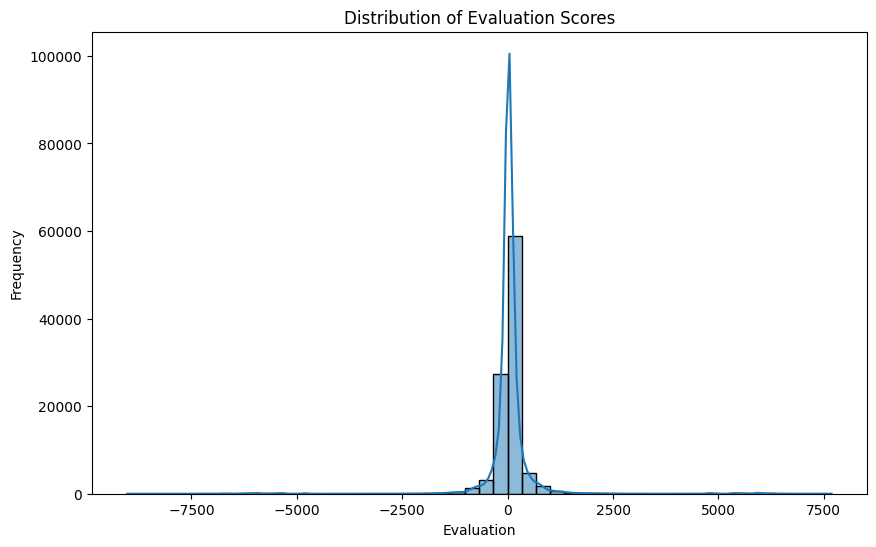

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Evaluation'], bins=50, kde=True)
plt.xlabel('Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Evaluation Scores')
plt.show()